In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    learning_curve,
    cross_val_score,
    validation_curve
)

from sklearn.preprocessing import (
    StandardScaler,
    OrdinalEncoder
)

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score
)

from sklearn.feature_selection import (
    SelectFromModel,
    RFECV
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


%matplotlib inline


In [5]:
pd.set_option('display.max_columns', None)


In [7]:
df = pd.read_csv('data.csv', index_col=0)


In [9]:
# Data cleaning and feature engineering
def clean_tenure(tenure):
    if pd.isna(tenure):
        return np.nan
    if tenure == '48+':
        return 48
    return float(tenure)

df['monthly_promo_discount'] = df['monthly_promo_discount'].fillna(0)
df['total_service_tenure_clean'] = df['total_service_tenure'].apply(clean_tenure)
df['current_service_tenure_clean'] = df['current_service_tenure'].apply(clean_tenure)
df['is_long_term_customer'] = (df['total_service_tenure_clean'] >= 12).astype(int)
df['resubscription_frequency'] = df['num_prev_service_subs'] / df['total_service_tenure_clean']
df['is_bundled'] = df['plan_name'].str.contains('Bundle', case=False, na=False).astype(int)
df['is_resubscriber'] = (df['num_prev_service_subs'] > 0).astype(int)
df['is_premium_plan'] = df['plan_name'].str.contains('Premium', case=False, na=False).astype(int)
df['effective_monthly_rate'] = df['monthly_price'] - df['monthly_promo_discount']
df['discount_percentage'] = (df['monthly_promo_discount'] / df['monthly_price'] * 100).fillna(0)

# Feature engineering: customer value and churn risk
df['customer_value_score'] = (
    (df['total_service_tenure_clean'] / 48) * 0.4 +  
    (df['effective_monthly_rate'] / df['effective_monthly_rate'].max()) * 0.3 +  
    (1 - df['discount_percentage'] / 100) * 0.3  
)
df['service_stability'] = df['current_service_tenure_clean'] / df['total_service_tenure_clean']
df['churn_risk_score'] = (
    (1 - df['service_stability']) * 0.3 +  
    (df['resubscription_frequency']) * 0.2 +  
    (1 - df['total_service_tenure_clean'] / 48) * 0.3 +  
    (df['discount_percentage'] / 100) * 0.2  
)

# Feature engineering: family status
df['family_status'] = df.apply(
    lambda x: 'Family' if x['has_children'] and x['marital_status_name'] == 'Married' 
              else 'Single Parent' if x['has_children'] 
              else 'Married No Kids' if x['marital_status_name'] == 'Married' 
              else 'Single No Kids', axis=1
)


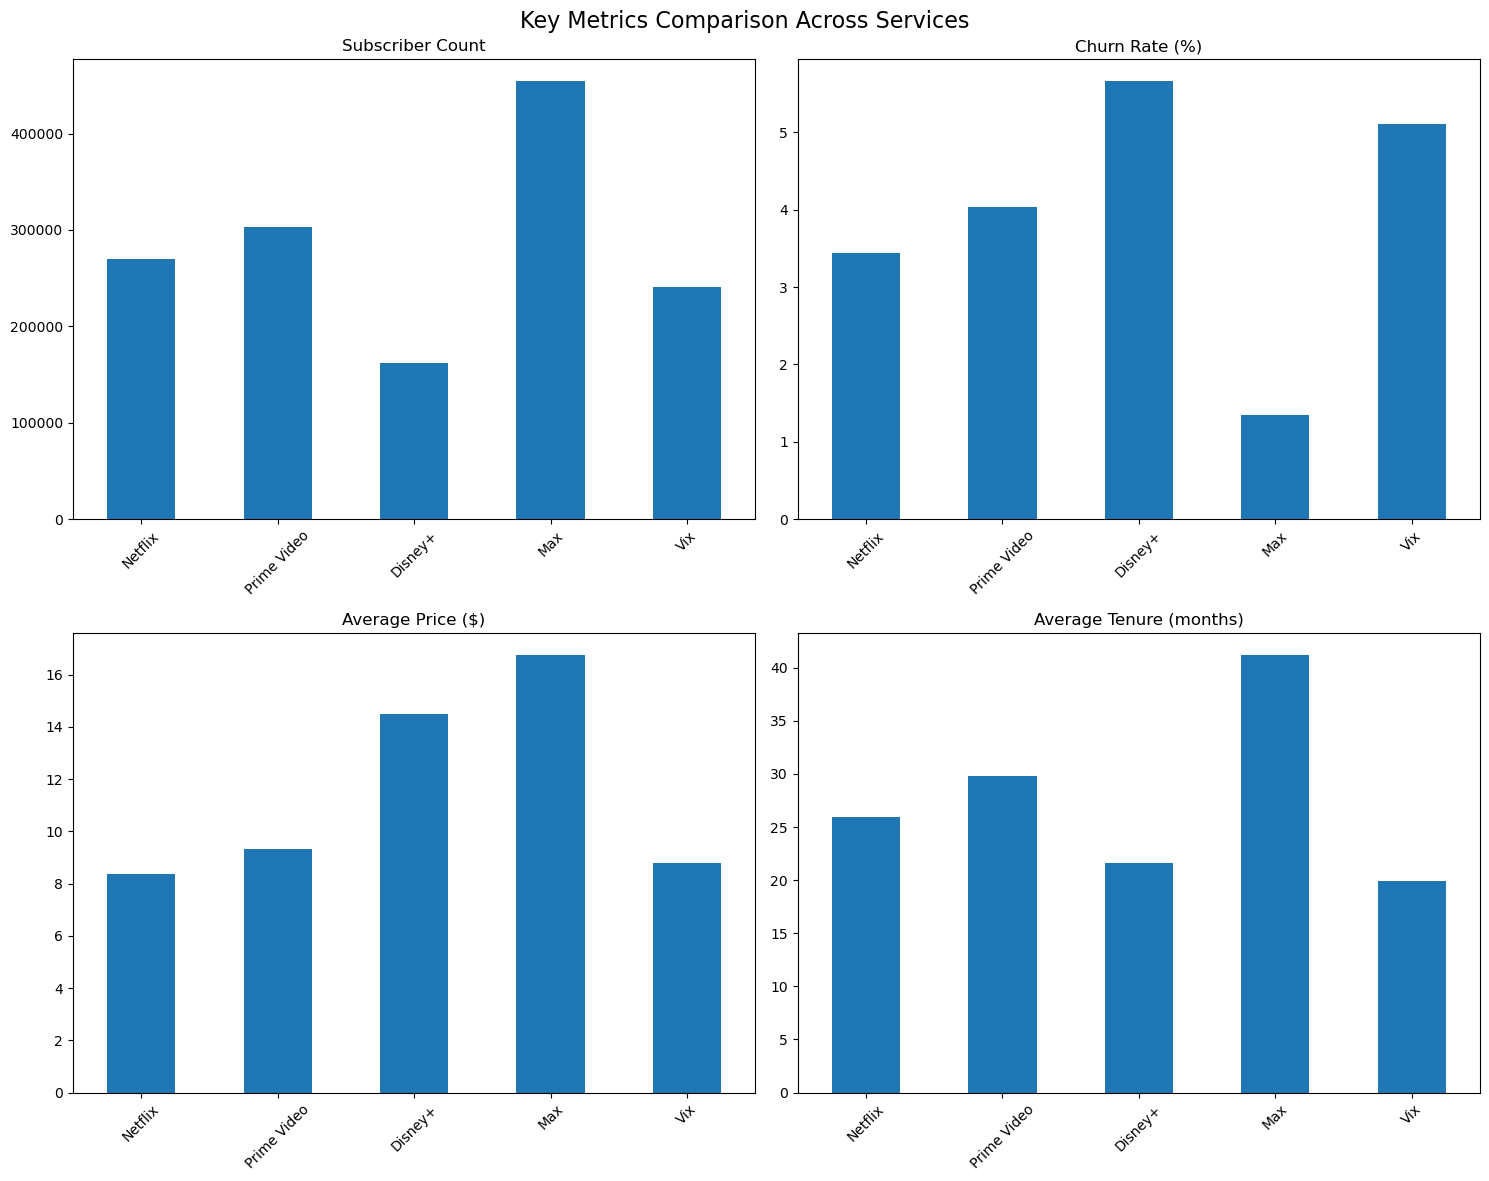

In [15]:
# Feature analysis and metrics calculation
def analyze_service_metrics():
    service_metrics = {}
    for service in df['service'].unique():
        service_data = df[df['service'] == service]
        metrics = {
            'subscriber_count': len(service_data),
            'churn_rate': service_data['is_cancel'].mean() * 100,
            'avg_price': service_data['monthly_price'].mean(),
            'avg_tenure': service_data['total_service_tenure_clean'].mean()
        }
        service_metrics[service] = metrics
    return pd.DataFrame(service_metrics).T

service_comparison = analyze_service_metrics()

# Visualizing the service comparison metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Key Metrics Comparison Across Services', fontsize=16)
# Subscriber Count
service_comparison['subscriber_count'].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Subscriber Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Churn Rate
service_comparison['churn_rate'].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Churn Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)

# Average Price
service_comparison['avg_price'].plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Average Price ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# Average Tenure
service_comparison['avg_tenure'].plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Average Tenure (months)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [17]:
# Calculate service metrics
service_comparison = analyze_service_metrics()
print("\nService Comparison Metrics:")
service_comparison.round(2)


Service Comparison Metrics:


,subscriber_count,churn_rate,avg_price,avg_tenure
Netflix,269361.0,3.44,8.37,25.96
Prime Video,303327.0,4.03,9.32,29.79
Disney+,162255.0,5.66,14.49,21.58
Max,454367.0,1.34,16.76,41.22
Vix,241293.0,5.11,8.79,19.88


<Figure size 1000x600 with 0 Axes>

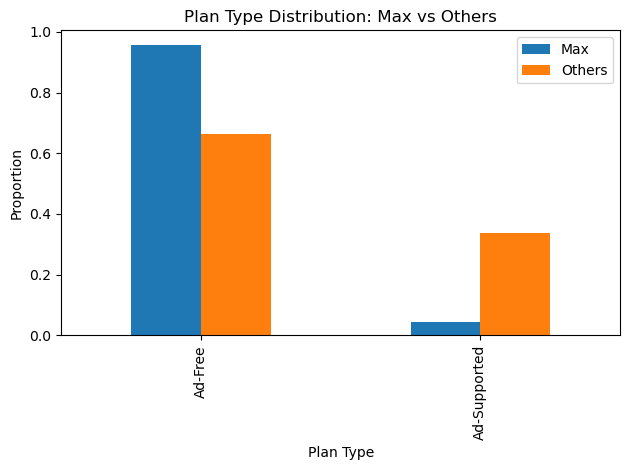

In [23]:
def analyze_unique_characteristics(df):
    max_data = df[df['service'] == 'Max']
    other_services = df[df['service'] != 'Max']
    
    # Plan distribution comparison
    plan_comparison = pd.DataFrame({
        'Max': max_data['plan_ads'].value_counts(normalize=True),
        'Others': other_services['plan_ads'].value_counts(normalize=True)
    })
    
    # Demographic comparison
    demographic_vars = ['age_group_name', 'household_income_name_v2', 'education_name']
    demographic_comparison = {}
    
    for var in demographic_vars:
        demographic_comparison[var] = pd.DataFrame({
            'Max': max_data[var].value_counts(normalize=True),
            'Others': other_services[var].value_counts(normalize=True)
        })
    
    return plan_comparison, demographic_comparison

plan_comp, demo_comp = analyze_unique_characteristics(df)

# Visualize plan distribution
plt.figure(figsize=(10, 6))
plan_comp.plot(kind='bar')
plt.title('Plan Type Distribution: Max vs Others')
plt.xlabel('Plan Type')
plt.ylabel('Proportion')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
def calculate_market_opportunity(df):
    max_data = df[df['service'] == 'Max']
    
    # Calculate current metrics
    current_subscribers = len(max_data)
    current_churn_rate = max_data['is_cancel'].mean()
    avg_revenue = max_data['monthly_price'].mean()
    
    # Calculate potential improvement impact
    churn_reduction_scenarios = [0.1, 0.2, 0.3]  # 10%, 20%, 30% reduction
    improvement_scenarios = []
    
    for reduction in churn_reduction_scenarios:
        new_churn_rate = current_churn_rate * (1 - reduction)
        retained_customers = current_subscribers * (reduction * current_churn_rate)
        additional_revenue = retained_customers * avg_revenue * 12
        
        improvement_scenarios.append({
            'churn_reduction': reduction * 100,
            'retained_customers': retained_customers,
            'annual_revenue_impact': additional_revenue
        })
    
    return pd.DataFrame(improvement_scenarios)

opportunity_analysis = calculate_market_opportunity(df)
print("\nMarket Opportunity Analysis:")
opportunity_analysis.round(2)


Market Opportunity Analysis:


,churn_reduction,retained_customers,annual_revenue_impact
0,10.0,608.9,122457.77
1,20.0,1217.8,244915.54
2,30.0,1826.7,367373.31


In [25]:
print("\nJustification for Selecting Max:")
print("\n1. Market Position:")
for metric in service_comparison.columns:
    max_value = service_comparison.loc['Max', metric]
    rank = service_comparison[metric].rank(ascending=False)['Max']
    print(f"- {metric}: {max_value:.2f} (Rank: {int(rank)} of {len(service_comparison)})")

print("\n2. Unique Characteristics:")
print("- Plan Type Distribution:")
print(plan_comp['Max'].round(3))

print("\n3. Market Opportunity:")
print(f"- Current Subscribers: {len(df[df['service'] == 'Max']):,}")
print(f"- Potential Annual Revenue Impact (20% churn reduction): "
      f"${opportunity_analysis.iloc[1]['annual_revenue_impact']:,.2f}")


Justification for Selecting Max:

1. Market Position:
- subscriber_count: 454367.00 (Rank: 1 of 5)
- churn_rate: 1.34 (Rank: 5 of 5)
- avg_price: 16.76 (Rank: 1 of 5)
- avg_tenure: 41.22 (Rank: 1 of 5)

2. Unique Characteristics:
- Plan Type Distribution:
plan_ads
Ad-Free         0.958
Ad-Supported    0.042
Name: Max, dtype: float64

3. Market Opportunity:
- Current Subscribers: 454,367
- Potential Annual Revenue Impact (20% churn reduction): $244,915.54


In [27]:
df = df[df['service'] == 'Max']


In [29]:
churn_metrics = {
    'overall_churn_rate': df['is_cancel'].mean(),
    'avg_tenure_churned': df[df['is_cancel'] == 1]['total_service_tenure_clean'].mean(),
    'avg_tenure_retained': df[df['is_cancel'] == 0]['total_service_tenure_clean'].mean(),
    'avg_price_churned': df[df['is_cancel'] == 1]['monthly_price'].mean(),
    'avg_price_retained': df[df['is_cancel'] == 0]['monthly_price'].mean()
}

print("\nKey Churn Metrics:")
for metric, value in churn_metrics.items():
    print(f"{metric}: {value:.2f}")


Key Churn Metrics:
overall_churn_rate: 0.01
avg_tenure_churned: 27.15
avg_tenure_retained: 41.25
avg_price_churned: 15.84
avg_price_retained: 16.78


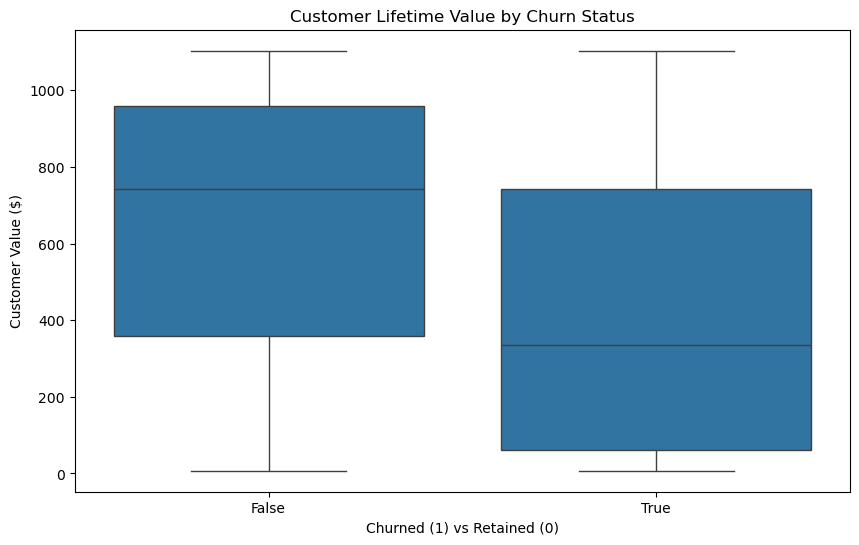

In [33]:
df['customer_value'] = df['monthly_price'] * df['total_service_tenure_clean']

plt.figure(figsize=(10, 6))
sns.boxplot(x='is_cancel', y='customer_value', data=df)
plt.title('Customer Lifetime Value by Churn Status')
plt.xlabel('Churned (1) vs Retained (0)')
plt.ylabel('Customer Value ($)')
plt.show()

In [35]:
avg_customer_value = df[df['is_cancel'] == 0]['customer_value'].mean()
total_churned = df['is_cancel'].sum()
potential_revenue_impact = avg_customer_value * total_churned

print(f"\nPotential Revenue Impact of Churn: ${potential_revenue_impact:,.2f}")


Potential Revenue Impact of Churn: $3,829,849.24


In [137]:
avg_customer_value

628.9783601911208

In [139]:
total_churned

6089

In [37]:
# Calculate overall churn rate and counts
total_customers = len(df)
churned_customers = df['is_cancel'].sum()
retained_customers = total_customers - churned_customers
churn_rate = (churned_customers / total_customers) * 100

print("Churn Analysis:")
print(f"Total Customers: {total_customers:,}")
print(f"Churned Customers: {churned_customers:,}")
print(f"Retained Customers: {retained_customers:,}")
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Analysis:
Total Customers: 454,367
Churned Customers: 6,089
Retained Customers: 448,278
Churn Rate: 1.34%


In [39]:
# Calculate Customer Lifetime Value (CLV) and other financial metrics
def calculate_financial_metrics(df):
    # Monthly Revenue per Customer
    df['monthly_revenue'] = df['monthly_price'] - df['monthly_promo_discount'].fillna(0)
    
    # Customer Lifetime Value (based on tenure and monthly revenue)
    df['customer_lifetime_value'] = df['monthly_revenue'] * df['total_service_tenure_clean']
    
    return df

In [41]:
df = calculate_financial_metrics(df)

In [43]:
def analyze_economic_impact(df):
    # Current customers analysis
    current_customers = len(df)
    churned_customers = df['is_cancel'].sum()
    retained_customers = current_customers - churned_customers
    
    # Revenue analysis
    avg_monthly_revenue = df['monthly_revenue'].mean()
    total_monthly_revenue = df['monthly_revenue'].sum()
    
    # Separate churned and retained customers
    churned_df = df[df['is_cancel'] == 1]
    retained_df = df[df['is_cancel'] == 0]
    
    # Calculate impact
    lost_monthly_revenue = churned_df['monthly_revenue'].sum()
    avg_clv_churned = churned_df['customer_lifetime_value'].mean()
    total_clv_lost = churned_df['customer_lifetime_value'].sum()
    
    # Create summary
    impact_summary = {
        'Total Customers': current_customers,
        'Churned Customers': churned_customers,
        'Churn Rate': churned_customers / current_customers * 100,
        'Avg Monthly Revenue per Customer': avg_monthly_revenue,
        'Total Monthly Revenue': total_monthly_revenue,
        'Lost Monthly Revenue': lost_monthly_revenue,
        'Avg CLV of Churned Customers': avg_clv_churned,
        'Total CLV Lost': total_clv_lost
    }
    
    return pd.Series(impact_summary)

impact = analyze_economic_impact(df)
print("\nEconomic Impact Analysis:")
impact.round(2)


Economic Impact Analysis:


Total Customers                      454367.00
Churned Customers                      6089.00
Churn Rate                                1.34
Avg Monthly Revenue per Customer         16.76
Total Monthly Revenue               4607350.39
Lost Monthly Revenue                  84627.07
Avg CLV of Churned Customers            407.64
Total CLV Lost                       271081.80
dtype: float64

In [45]:
def project_future_impact(df, months_ahead=12):
    current_monthly_loss = df[df['is_cancel'] == 1]['monthly_revenue'].sum()
    current_churn_rate = df['is_cancel'].mean()
    
    # Project future losses
    remaining_customers = len(df[df['is_cancel'] == 0])
    projected_losses = []
    
    for month in range(1, months_ahead + 1):
        projected_churn = remaining_customers * current_churn_rate
        projected_revenue_loss = projected_churn * df['monthly_revenue'].mean()
        
        projected_losses.append({
            'Month': month,
            'Projected_Churned_Customers': projected_churn,
            'Projected_Revenue_Loss': projected_revenue_loss,
            'Cumulative_Revenue_Loss': projected_revenue_loss * month
        })
        
        remaining_customers -= projected_churn
    
    return pd.DataFrame(projected_losses)

future_impact = project_future_impact(df)
print("\nProjected 12-Month Impact:")
future_impact.round(2)


Projected 12-Month Impact:


,Month,Projected_Churned_Customers,Projected_Revenue_Loss,Cumulative_Revenue_Loss
0,1,6007.40,100680.59,100680.59
1,2,5926.90,99331.36,198662.72
2,3,5847.47,98000.22,294000.65
3,4,5769.11,96686.91,386747.63
4,5,5691.79,95391.20,476956.01
5,6,5615.52,94112.86,564677.15
6,7,5540.26,92851.65,649961.52
7,8,5466.02,91607.34,732858.68
8,9,5392.77,90379.70,813417.30
9,10,5320.50,89168.52,891685.16


In [47]:
def retention_cost_benefit_analysis(df):
    avg_clv = df[df['is_cancel'] == 0]['customer_lifetime_value'].mean()
    monthly_revenue_per_customer = df['monthly_revenue'].mean()
    
    # Assume different retention costs and success rates
    retention_scenarios = []
    costs_per_customer = [10, 20, 50, 100]  # Example retention costs
    success_rates = [0.1, 0.2, 0.3, 0.5]    # Example success rates
    
    for cost in costs_per_customer:
        for rate in success_rates:
            retained_revenue = monthly_revenue_per_customer * 12 * rate
            roi = (retained_revenue - cost) / cost
            
            retention_scenarios.append({
                'Retention_Cost': cost,
                'Success_Rate': rate,
                'Annual_Revenue_Saved': retained_revenue,
                'ROI': roi
            })
    
    return pd.DataFrame(retention_scenarios)

# Calculate retention scenarios
retention_analysis = retention_cost_benefit_analysis(df)
print("\nRetention Investment Analysis:")
retention_analysis.round(2)


Retention Investment Analysis:


,Retention_Cost,Success_Rate,Annual_Revenue_Saved,ROI
0,10,0.1,20.11,1.01
1,10,0.2,40.22,3.02
2,10,0.3,60.33,5.03
3,10,0.5,100.56,9.06
4,20,0.1,20.11,0.01
5,20,0.2,40.22,1.01
6,20,0.3,60.33,2.02
7,20,0.5,100.56,4.03
8,50,0.1,20.11,-0.60
9,50,0.2,40.22,-0.20


In [49]:
# Summary of Key Financial Metrics
print("\nKey Financial Impact Metrics:")
print(f"1. Monthly Revenue at Risk: ${impact['Lost Monthly Revenue']:,.2f}")
print(f"2. Average CLV Lost per Churned Customer: ${impact['Avg CLV of Churned Customers']:,.2f}")
print(f"3. Total CLV Lost: ${impact['Total CLV Lost']:,.2f}")
print(f"4. Projected Annual Revenue Loss: ${future_impact['Cumulative_Revenue_Loss'].iloc[-1]:,.2f}")


Key Financial Impact Metrics:
1. Monthly Revenue at Risk: $84,627.07
2. Average CLV Lost per Churned Customer: $407.64
3. Total CLV Lost: $271,081.80
4. Projected Annual Revenue Loss: $1,041,535.49


# Developing the model using the service Max

In [54]:
df.shape

(454367, 43)

In [56]:
df['monthly_promo_discount'] = df['monthly_promo_discount'].fillna(0)

In [58]:
df['is_cancel'].value_counts(normalize=True)

is_cancel
False    0.986599
True     0.013401
Name: proportion, dtype: float64

In [60]:
numeric_features = [
    'total_service_tenure_clean', 'current_service_tenure_clean',
    'monthly_price', 
    'service_stability', 'effective_monthly_rate', 
    'churn_risk_score'
]

categorical_features = [
    'plan_term_length', 'plan_ads', 'age_group_name',
    'education_name', 'ethnicity_name_v2', 'gender_name',
    'household_income_name_v2', 'marital_status_name', 'state_name'
]


In [62]:
X = df[numeric_features + categorical_features]
y = df['is_cancel']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [66]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [68]:
model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [70]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [3, 4, 5],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__subsample': [0.8, 0.9, 1.0]
}


In [72]:
random_search = RandomizedSearchCV(
    model, param_grid, n_iter=20, cv=5, 
    scoring='roc_auc', n_jobs=-1, random_state=42
)

In [74]:
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [76]:
random_search.fit(X_train_resampled, y_train_resampled)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['total_service_tenure_clean',
                                                                                'current_service_tenure_clean',
                                                                                'monthly_price',
                                                                                'service_stability',
                                                                                'effective_monthly_rate',
                                                                                'churn_risk_score']),
                                                                              ('cat',
                                                                               Pipe...
                                                                                'state_name'])])),
                                             ('classifier',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01, 0.1,
                                                                      0.3],
                                        'classifier__max_depth': [3, 4, 5],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__subsample': [0.8, 0.9,
                                                                  1.0]},
                   random_state=42, scoring='roc_auc')

In [77]:
best_model = random_search.best_estimator_

In [78]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [82]:
print("\nBest parameters:", random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best parameters: {'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.75      0.86     89656
        True       0.05      0.88      0.09      1218

    accuracy                           0.75     90874
   macro avg       0.52      0.81      0.47     90874
weighted avg       0.99      0.75      0.85     90874



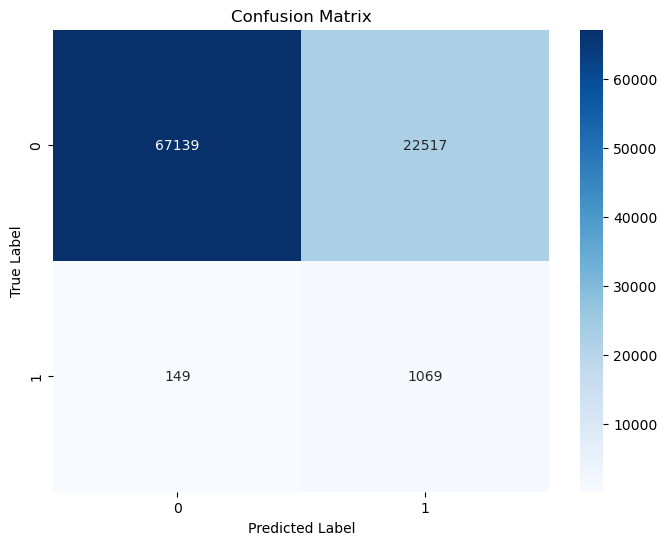

In [84]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

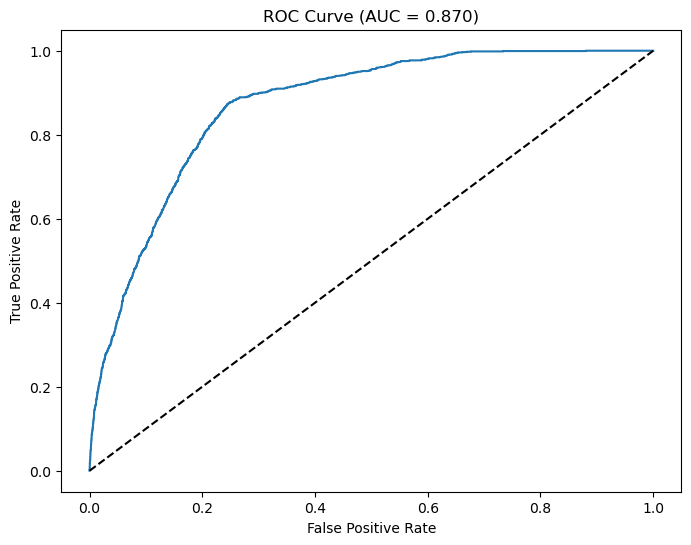

In [86]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.show()

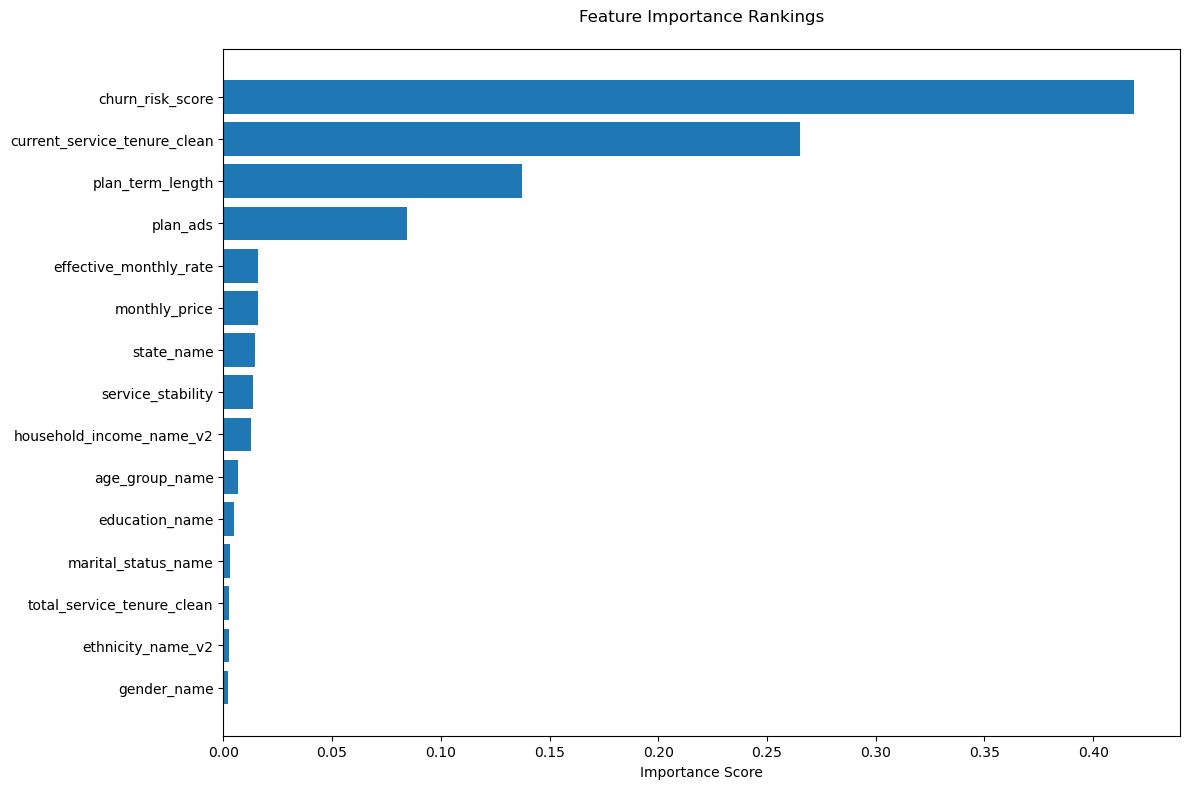

In [88]:
plt.figure(figsize=(12, 8))
importance_df = pd.DataFrame({
    'feature': numeric_features + categorical_features,
    'importance': best_model.named_steps['classifier'].feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=True)  
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance Rankings', pad=20)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

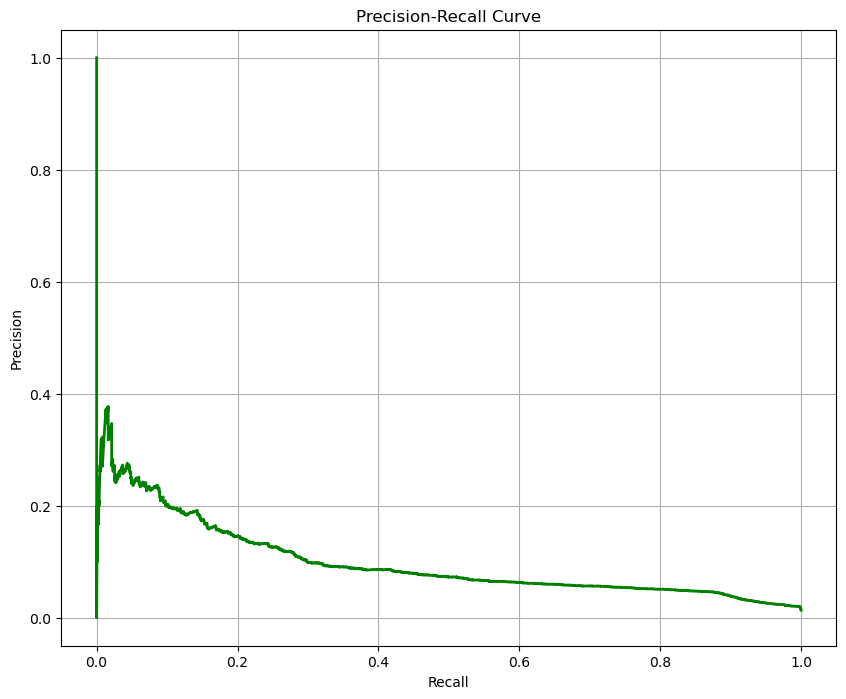

In [92]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(recalls, precisions, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [94]:
threshold_metrics = []
thresholds_to_test = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    threshold_metrics.append({
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_threshold),
        'recall': recall_score(y_test, y_pred_threshold),
        'f1_score': f1_score(y_test, y_pred_threshold),
        'accuracy': (y_pred_threshold == y_test).mean()
    })

threshold_df = pd.DataFrame(threshold_metrics)

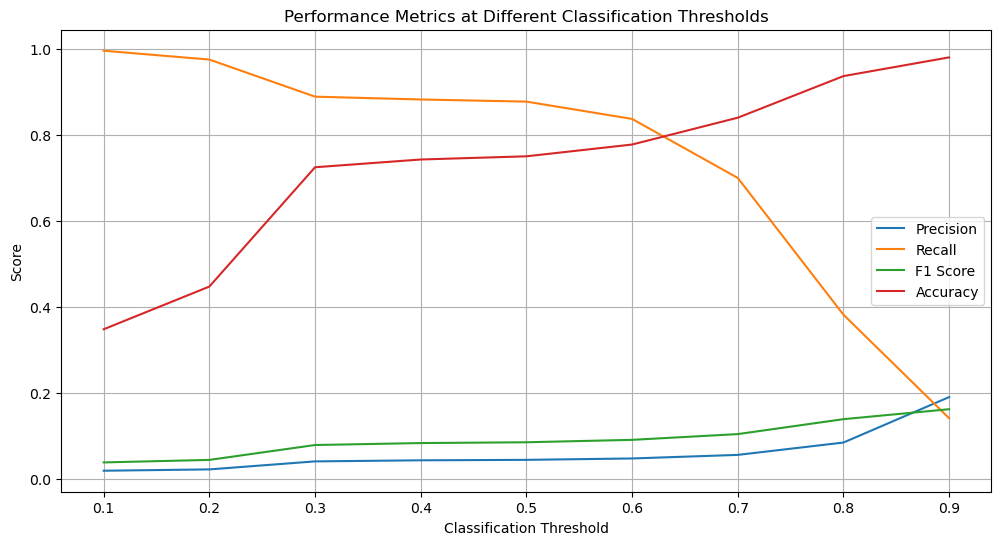

In [96]:
plt.figure(figsize=(12, 6))
for column in ['precision', 'recall', 'f1_score', 'accuracy']:
    plt.plot(threshold_df['threshold'], threshold_df[column], label=column.replace('_', ' ').title())
plt.xlabel('Classification Threshold')
plt.ylabel('Score')
plt.title('Performance Metrics at Different Classification Thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

print("\nPerformance metrics at different thresholds:")
print(threshold_df.round(3))


Detailed Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.75      0.86     89656
        True       0.05      0.88      0.09      1218

    accuracy                           0.75     90874
   macro avg       0.52      0.81      0.47     90874
weighted avg       0.99      0.75      0.85     90874


Performance metrics at different thresholds:
   threshold  precision  recall  f1_score  accuracy
0        0.1      0.020   0.996     0.039     0.349
1        0.2      0.023   0.975     0.045     0.448
2        0.3      0.042   0.889     0.080     0.725
3        0.4      0.044   0.883     0.084     0.743
4        0.5      0.045   0.878     0.086     0.751
5        0.6      0.049   0.837     0.092     0.778
6        0.7      0.057   0.700     0.105     0.840
7        0.8      0.086   0.383     0.140     0.937
8        0.9      0.191   0.142     0.163     0.980


## Checking for Overfitting

In [103]:
def plot_learning_curves(estimator, X, y, title="Learning Curves"):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std,
                     val_mean + val_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('ROC AUC Score')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [105]:
def plot_validation_curves(estimator, X, y):
    param_range = np.logspace(-3, 3, 7)
    
    # Test different max_depths
    train_scores, val_scores = validation_curve(
        estimator, X, y,
        param_name="classifier__max_depth",
        param_range=[3, 4, 5, 6, 7, 8, 9, 10],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(param_range, np.mean(val_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Max Depth')
    plt.ylabel('ROC AUC Score')
    plt.title('Validation Curve - Max Depth')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [107]:
def print_cv_scores(estimator, X, y):
    cv_scores = cross_val_score(estimator, X, y, cv=5, scoring='roc_auc')
    print("\nCross-validation scores:")
    print(f"Mean ROC AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    return cv_scores

In [109]:
def compare_train_test_metrics(estimator, X_train, X_test, y_train, y_test):
    
    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)
    
    y_train_proba = estimator.predict_proba(X_train)[:, 1]
    y_test_proba = estimator.predict_proba(X_test)[:, 1]
    
    metrics = {
        'Accuracy': (accuracy_score(y_train, y_train_pred),
                    accuracy_score(y_test, y_test_pred)),
        'ROC AUC': (roc_auc_score(y_train, y_train_proba),
                   roc_auc_score(y_test, y_test_proba))
    }
    print("\nTraining vs Validation Performance:")
    for metric, (train_score, test_score) in metrics.items():
        print(f"{metric}:")
        print(f"  Training: {train_score:.3f}")
        print(f"  Validation: {test_score:.3f}")
        print(f"  Difference: {abs(train_score - test_score):.3f}")

In [111]:
model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

In [113]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_service_tenure_clean',
                                                   'current_service_tenure_clean',
                                                   'monthly_price',
                                                   'service_stability',
                                                   'effective_monthly_rate',
                                                   'churn_risk_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImput...
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['plan_term_length',
                                                   'plan_ads', 'age_group_name',
                                                   'education_name',
                                                   'ethnicity_name_v2',
                                                   'gender_name',
                                                   'household_income_name_v2',
                                                   'marital_status_name',
                                                   'state_name'])])),
                ('undersampler', RandomUnderSampler(random_state=42)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

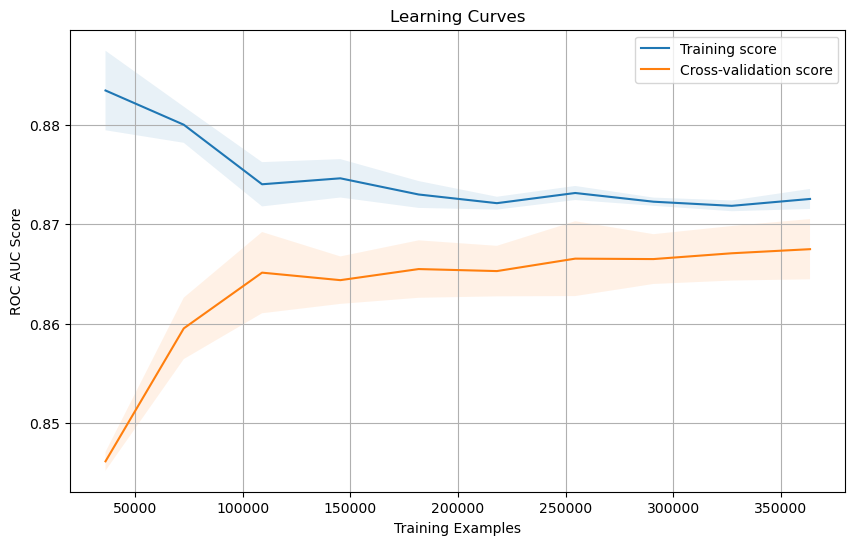

In [127]:
plot_learning_curves(model, X, y)


In [128]:
cv_scores = print_cv_scores(model, X, y)



Cross-validation scores:
Mean ROC AUC: 0.867 (+/- 0.006)


In [129]:
compare_train_test_metrics(model, X_train, X_test, y_train, y_test)


Training vs Validation Performance:
Accuracy:
  Training: 0.742
  Validation: 0.744
  Difference: 0.002
ROC AUC:
  Training: 0.871
  Validation: 0.876
  Difference: 0.005


In [121]:
def feature_importance_stability(estimator, X, y, n_iterations=10):
    feature_names = numeric_features + categorical_features
    importance_df = pd.DataFrame()
    
    for i in range(n_iterations):
        X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(X, y, test_size=0.2)
        
        estimator.fit(X_train_iter, y_train_iter)
        
        # Get feature importance
        importance_df[f'iter_{i}'] = estimator.named_steps['classifier'].feature_importances_
    
    importance_df.index = feature_names
    
    # Calculate mean and std of feature importance
    importance_stats = pd.DataFrame({
        'mean_importance': importance_df.mean(axis=1),
        'std_importance': importance_df.std(axis=1)
    })
    plt.figure(figsize=(12, 6))
    importance_stats = importance_stats.sort_values('mean_importance', ascending=True)
    plt.barh(importance_stats.index, importance_stats['mean_importance'],
             xerr=importance_stats['std_importance'], capsize=5)
    plt.title('Feature Importance Stability')
    plt.xlabel('Mean Importance (with standard deviation)')
    plt.tight_layout()
    plt.show()
    
    return importance_stats

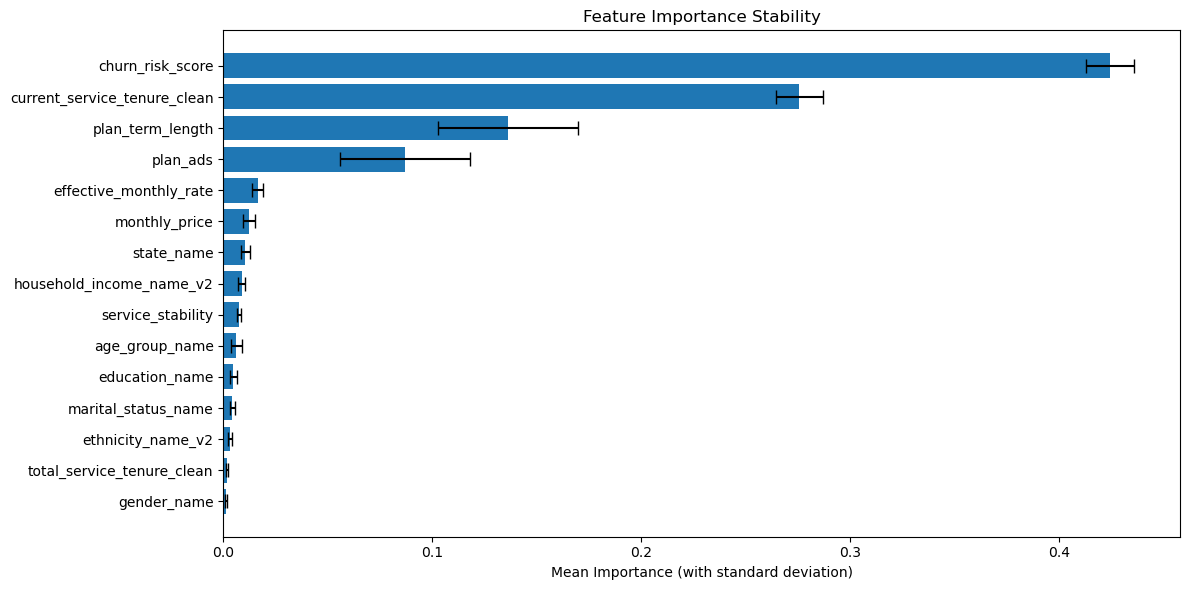

                              mean_importance  std_importance
churn_risk_score                     0.424522        0.011647
current_service_tenure_clean         0.275659        0.011282
plan_term_length                     0.136358        0.033430
plan_ads                             0.086768        0.031142
effective_monthly_rate               0.016455        0.002693
monthly_price                        0.012117        0.002803
state_name                           0.010481        0.002069
household_income_name_v2             0.008899        0.001672
service_stability                    0.007315        0.000913
age_group_name                       0.006249        0.002753
education_name                       0.004847        0.001541
marital_status_name                  0.004188        0.001193
ethnicity_name_v2                    0.003218        0.000953
total_service_tenure_clean           0.001732        0.000645
gender_name                          0.001194        0.000493


In [123]:
importance_stats = feature_importance_stability(model, X, y)
print(importance_stats.sort_values('mean_importance', ascending=False))